## BiLSTM을 이용한 개체명 인식(Named Entity Recognition, NER)



<br>

<br>

## 개체명 인식 데이터에 대한 이해와 전처리
링크 : https://www.kaggle.com/abhinavwalia95/entity-annotated-corpus

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

<br>

- 첫번째 열 'Sentence :#' :

  Sentence: 1이 등장하고 Null 값이 이어지다가 다시 Sentence: 2가 등장하고 다시 Null 값이 이어지다가 Sentence: 3이 등장하고 다시 Null 값이 이어지다가를 반복

  **이는 하나의 문장을 여러 행으로 나눠놓은 것**


In [13]:
data = pd.read_csv("ner_dataset.csv", encoding="latin1")
data.head(5)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


In [14]:
print('데이터프레임 행의 개수 : {}'.format(len(data)))

데이터프레임 행의 개수 : 1048575


In [15]:
print('데이터에 Null 값이 있는지 유무 : ' + str(data.isnull().values.any()))

데이터에 Null 값이 있는지 유무 : True


In [16]:
print('어떤 열에 Null값이 있는지 출력')
print('==============================')
data.isnull().sum()

어떤 열에 Null값이 있는지 출력


Sentence #    1000616
Word                0
POS                 0
Tag                 0
dtype: int64

<br>

- 데이터는 47,959개의 문장이 있으며,

  문장들은 35,178개의 단어를 가지고 17개 종류의 개체명 태깅을 가짐

In [17]:
print('sentence # 열의 중복을 제거한 값의 개수 : {}'.format(data['Sentence #'].nunique()))
print('Word 열의 중복을 제거한 값의 개수 : {}'.format(data.Word.nunique()))
print('Tag 열의 중복을 제거한 값의 개수 : {}'.format(data.Tag.nunique()))

sentence # 열의 중복을 제거한 값의 개수 : 47959
Word 열의 중복을 제거한 값의 개수 : 35178
Tag 열의 중복을 제거한 값의 개수 : 17


<br>

#### 개체명 태깅 개수의 분포를 확인

In [18]:
print('Tag 열의 각각의 값의 개수 카운트')
print('================================')
print(data.groupby('Tag').size().reset_index(name='count'))

Tag 열의 각각의 값의 개수 카운트
      Tag   count
0   B-art     402
1   B-eve     308
2   B-geo   37644
3   B-gpe   15870
4   B-nat     201
5   B-org   20143
6   B-per   16990
7   B-tim   20333
8   I-art     297
9   I-eve     253
10  I-geo    7414
11  I-gpe     198
12  I-nat      51
13  I-org   16784
14  I-per   17251
15  I-tim    6528
16      O  887908


<br>

- **BIO 표현 방법에서 아무런 태깅도 의미하지 않는 O가 가장 887,908개로 가장 많은 개수를 차지**

<br>

### 데이터 가공
- Null 값을 제거
  - **Null 값을 가진 행의 바로 앞의 행의 값으로 Null 값을 채움**

In [19]:
data = data.fillna(method="ffill")
print(data.tail())

              Sentence #       Word  POS Tag
1048570  Sentence: 47959       they  PRP   O
1048571  Sentence: 47959  responded  VBD   O
1048572  Sentence: 47959         to   TO   O
1048573  Sentence: 47959        the   DT   O
1048574  Sentence: 47959     attack   NN   O


In [20]:
print('데이터에 Null 값이 있는지 유무 : ' + str(data.isnull().values.any()))

데이터에 Null 값이 있는지 유무 : False


<br>

#### 모든 단어를 소문자화하여 단어의 개수를 감소

In [21]:
data['Word'] = data['Word'].str.lower()
print('Word 열의 중복을 제거한 값의 개수 : {}'.format(data.Word.nunique()))

Word 열의 중복을 제거한 값의 개수 : 31817


In [22]:
print(data[:5])

    Sentence #           Word  POS Tag
0  Sentence: 1      thousands  NNS   O
1  Sentence: 1             of   IN   O
2  Sentence: 1  demonstrators  NNS   O
3  Sentence: 1           have  VBP   O
4  Sentence: 1        marched  VBN   O


<br>

#### 하나의 문장에 등장한 단어와 개체명 태깅 정보끼리 쌍(pair)으로 묶음
- 1,000,616개의 행의 개수가 각 문장당 하나의 샘플로 묶이면서 47,959개의 샘플이 됨

In [23]:
func = lambda temp: [(w, t) for w, t in zip(temp["Word"].values.tolist(), temp["Tag"].values.tolist())]
tagged_sentences=[t for t in data.groupby("Sentence #").apply(func)]

print("전체 샘플 개수: {}".format(len(tagged_sentences)))

전체 샘플 개수: 47959


In [24]:
print(tagged_sentences[0])

[('thousands', 'O'), ('of', 'O'), ('demonstrators', 'O'), ('have', 'O'), ('marched', 'O'), ('through', 'O'), ('london', 'B-geo'), ('to', 'O'), ('protest', 'O'), ('the', 'O'), ('war', 'O'), ('in', 'O'), ('iraq', 'B-geo'), ('and', 'O'), ('demand', 'O'), ('the', 'O'), ('withdrawal', 'O'), ('of', 'O'), ('british', 'B-gpe'), ('troops', 'O'), ('from', 'O'), ('that', 'O'), ('country', 'O'), ('.', 'O')]


<br>

#### 훈련 데이터에서 단어에 해당되는 부분과 개체명 태깅 정보에 해당되는 부분을 분리
- **[('thousands', 'O'), ('of', 'O')]와 같은 문장 샘플이 있다면 thousands와 of는 같이 저장하고, O와 O를 같이 저장**


In [25]:
sentences, ner_tags = [], []

for tagged_sentence in tagged_sentences:

    # 각 샘플에서 단어들은 sentence에 개체명 태깅 정보들은 tag_info에 저장
    sentence, tag_info = zip(*tagged_sentence)
    sentences.append(list(sentence)) # 각 샘플에서 단어 정보만 저장
    ner_tags.append(list(tag_info)) # 각 샘플에서 개체명 태깅 정보만 저장

In [26]:
print(sentences[0])
print(ner_tags[0])

['thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'london', 'to', 'protest', 'the', 'war', 'in', 'iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'british', 'troops', 'from', 'that', 'country', '.']
['O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'O']


<br>

#### 데이터 길이 분포 확인
- 길이가 대체적으로 0~40의 길이를 가지는 것을 보여줍니다. 길이가 가장 긴 샘플의 길이는 104

샘플의 최대 길이 : 104
샘플의 평균 길이 : 21.863988


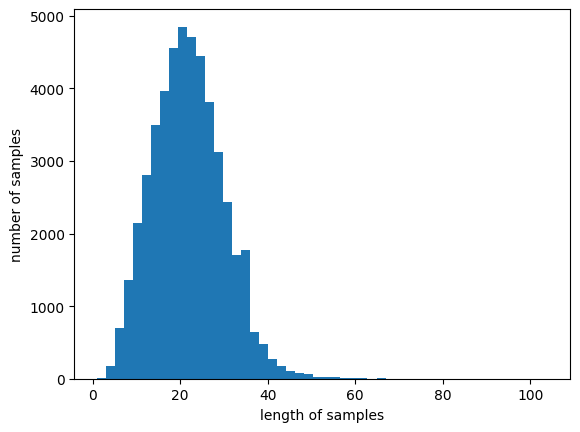

In [27]:
print('샘플의 최대 길이 : %d' % max(len(l) for l in sentences))
print('샘플의 평균 길이 : %f' % (sum(map(len, sentences))/len(sentences)))

plt.hist([len(s) for s in sentences], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

<br>

### 정수 인코딩
- 모든 단어를 사용하며 인덱스 1에는 단어 'OOV'를 할당.


In [28]:
src_tokenizer = Tokenizer(oov_token='OOV')
tar_tokenizer = Tokenizer(lower=False) # 태깅 정보들은 내부적으로 대문자를 유지한 채 저장

src_tokenizer.fit_on_texts(sentences)
tar_tokenizer.fit_on_texts(ner_tags)

In [29]:
vocab_size = len(src_tokenizer.word_index) + 1
tag_size = len(tar_tokenizer.word_index) + 1

print('단어 집합의 크기 : {}'.format(vocab_size))
print('개체명 태깅 정보 집합의 크기 : {}'.format(tag_size))

단어 집합의 크기 : 31819
개체명 태깅 정보 집합의 크기 : 18


In [30]:
print('단어 OOV의 인덱스 : {}'.format(src_tokenizer.word_index['OOV']))

단어 OOV의 인덱스 : 1


In [31]:
X_data = src_tokenizer.texts_to_sequences(sentences)
y_data = tar_tokenizer.texts_to_sequences(ner_tags)

In [32]:
print(X_data[0])
print(y_data[0])

[254, 6, 967, 16, 1795, 238, 468, 7, 523, 2, 129, 5, 61, 9, 571, 2, 833, 6, 186, 90, 22, 15, 56, 3]
[1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 8, 1, 1, 1, 1, 1]


<br>

- 모델 훈련 후 결과 확인을 위해,

  인덱스로부터 단어를 리턴하는 index_to_word와 인덱스로부터 개체명 태깅 정보를 리턴하는 index_to_ner생성
  - 인덱스 0은 'PAD'란 단어를 할당

In [33]:
word_to_index = src_tokenizer.word_index
index_to_word = src_tokenizer.index_word
ner_to_index = tar_tokenizer.word_index
index_to_ner = tar_tokenizer.index_word
index_to_ner[0] = 'PAD'

print(index_to_ner)

{1: 'O', 2: 'B-geo', 3: 'B-tim', 4: 'B-org', 5: 'I-per', 6: 'B-per', 7: 'I-org', 8: 'B-gpe', 9: 'I-geo', 10: 'I-tim', 11: 'B-art', 12: 'B-eve', 13: 'I-art', 14: 'I-eve', 15: 'B-nat', 16: 'I-gpe', 17: 'I-nat', 0: 'PAD'}


- 샘플의 정수 시퀀스를 텍스트 시퀀스로 변환하는 디코딩

In [34]:
decoded = []

for index in X_data[0] :
    decoded.append(index_to_word[index])

print('기존의 문장 : {}'.format(sentences[0]))
print('디코딩 문장 : {}'.format(decoded))

기존의 문장 : ['thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'london', 'to', 'protest', 'the', 'war', 'in', 'iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'british', 'troops', 'from', 'that', 'country', '.']
디코딩 문장 : ['thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'london', 'to', 'protest', 'the', 'war', 'in', 'iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'british', 'troops', 'from', 'that', 'country', '.']


<br>

### 패딩
- 70의 길이로 패딩

In [35]:
max_len = 70

X_data = pad_sequences(X_data, padding='post', maxlen=max_len)
y_data = pad_sequences(y_data, padding='post', maxlen=max_len)

<br>

#### 훈련/테스트 데이터 분리

In [36]:
X_train, X_test, y_train_int, y_test_int = train_test_split(X_data, y_data, test_size=.2, random_state=777)

<br>

#### 레이블에 대하여 원-핫 인코딩

In [37]:
y_train = to_categorical(y_train_int, num_classes=tag_size)
y_test = to_categorical(y_test_int, num_classes=tag_size)

In [38]:
print('훈련 샘플 문장의 크기 : {}'.format(X_train.shape))
print('훈련 샘플 레이블(정수 인코딩)의 크기 : {}'.format(y_train_int.shape))
print('훈련 샘플 레이블(원-핫 인코딩)의 크기 : {}'.format(y_train.shape))
print('테스트 샘플 문장의 크기 : {}'.format(X_test.shape))
print('테스트 샘플 레이블(정수 인코딩)의 크기 : {}'.format(y_test_int.shape))
print('테스트 샘플 레이블(원-핫 인코딩)의 크기 : {}'.format(y_test.shape))

훈련 샘플 문장의 크기 : (38367, 70)
훈련 샘플 레이블(정수 인코딩)의 크기 : (38367, 70)
훈련 샘플 레이블(원-핫 인코딩)의 크기 : (38367, 70, 18)
테스트 샘플 문장의 크기 : (9592, 70)
테스트 샘플 레이블(정수 인코딩)의 크기 : (9592, 70)
테스트 샘플 레이블(원-핫 인코딩)의 크기 : (9592, 70, 18)


<br>

### 양방향 LSTM을 이용한 개체명 인식

In [39]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, InputLayer, Bidirectional, TimeDistributed, Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

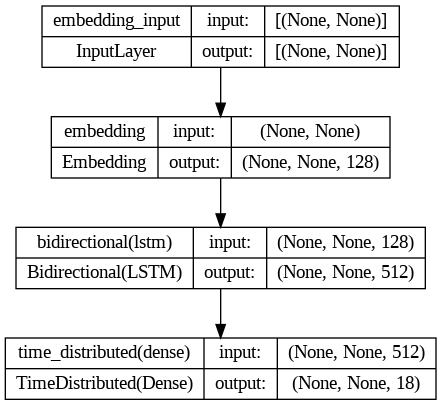

In [40]:
embedding_dim = 128
hidden_units = 256

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, mask_zero=True))
model.add(Bidirectional(LSTM(hidden_units, return_sequences=True)))
model.add(TimeDistributed(Dense(tag_size, activation=('softmax'))))
model.compile(loss='categorical_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])

plot_model(model, show_shapes=True)

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])

history = model.fit(X_train, y_train, batch_size=128, epochs=6, validation_split=0.1,
                    verbose=False)

<br>

### 모델 평가

In [ ]:
i = 13
y_predicted = model.predict(np.array([X_test[i]])) # 입력한 테스트용 샘플에 대해서 예측 y를 리턴
y_predicted = np.argmax(y_predicted, axis=-1) # 확률 벡터를 정수 인코딩으로 변경
labels = np.argmax(y_test[i], -1) # 원-핫 인코딩을 다시 정수 인코딩으로 변경

print("{:15}|{:5}|{}".format("단어", "실제값", "예측값"))
print(35 * "-")

for word, tag, pred in zip(X_test[i], labels, y_predicted[0]):

    if word != 0: # PAD값은 제외함.
        print("{:17}: {:7} {}".format(index_to_word[word], index_to_ner[tag], index_to_ner[pred]))

1/1 [==============================] - 3s 3s/step
단어             |실제값  |예측값
-----------------------------------
the              : O       O
statement        : O       O
came             : O       O
as               : O       O
u.n.             : B-org   B-org
secretary-general: I-org   I-org
kofi             : B-per   B-per
annan            : I-per   I-per
met              : O       O
with             : O       O
officials        : O       O
in               : O       O
amman            : B-geo   B-geo
to               : O       O
discuss          : O       O
wednesday        : B-tim   B-tim
's               : O       O
attacks          : O       O
.                : O       O


<br>

### F1-Score
- 개체명 인식에서는 그 어떤 개체도 아니라는 의미의 'O'라는 태깅이 존재
- **그런데 이런 정보는 보통 대다수의 레이블을 차지하기 때문에 기존에 사용했던 정확도(accuracy)를 평가 방법으로 사용하는 것이 적절하지 않을 수 있음**

<br>

-  모델이 단 1개의 개체도 맞추지 못하고 전부 'O'로 예상했을 경우

  $\rightarrow$ **실제값에서도 대부분의 값이 'O'이기 때문에 그 어떤 개체도 찾지 못하였음에도 74%의 정확도**

In [41]:
labels = ['B-PER', 'I-PER', 'O', 'O', 'B-MISC', 'O','O','O','O','O','O','O','O','O','O','B-PER','I-PER','O','O','O','O','O','O','B-MISC','I-MISC','I-MISC','O','O','O','O','O','O','B-PER','I-PER','O','O','O','O','O']
predicted = ['O'] * len(labels)

print('예측값 :',predicted)

예측값 : ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [42]:
hit = 0

for tag, pred in zip(labels, predicted):
    if tag == pred:
        hit +=1

accuracy = hit/len(labels)

print("정확도: {:.1%}".format(accuracy))

정확도: 74.4%


<br>

#### 정밀도 & 재현율

#### $\text{정밀도} = \frac{TP}{TP + FP} = \text{특정 개체라고 예측한 경우 중에서 실제 특정 개체로 판명되어 예측이 일치한 비율}$

#### $\text{재현률} = \frac{TP}{TP + FN} = \text{전체 특정 개체 중에서 실제 특정 개체라고 정답을 맞춘 비율}$

<br>

- **정밀도와 재현률로부터 조화 평균(harmonic mean)을 구한 것을 f1-score**

$$f1\ score = 2 × \frac{\text{정밀도 × 재현률}}{\text{정밀도 + 재현률}}$$

```python
pip install seqeval
```

<br>

#### `seqeval.metrics.classifcation_report`

In [ ]:
from seqeval.metrics import classification_report, f1_score

In [58]:
def sequences_to_tag(sequences):

    result = []

    for sequence in sequences:

        temp = []

        for pred in sequence:

            pred_index = np.argmax(pred) # 예를 들어 [0, 0, 1, 0 ,0]라면 1의 인덱스인 2를 리턴
            temp.append(index_to_ner[pred_index].replace("PAD", "O")) # 'PAD'는 'O'로 변경

        result.append(temp)

    return result

In [ ]:
y_predicted = model.predict([X_test])
pred_tags = sequences_to_tag(y_predicted)
test_tags = sequences_to_tag(y_test)

In [ ]:
print(classification_report(test_tags, pred_tags))

              precision    recall  f1-score   support

         art       0.16      0.05      0.07        63
         eve       0.38      0.27      0.31        52
         geo       0.81      0.85      0.83      7620
         gpe       0.95      0.94      0.95      3145
         nat       0.45      0.24      0.32        37
         org       0.62      0.55      0.58      4033
         per       0.72      0.71      0.72      3545
         tim       0.87      0.83      0.85      4067

   micro avg       0.80      0.78      0.79     22562
   macro avg       0.62      0.55      0.58     22562
weighted avg       0.79      0.78      0.78     22562



In [ ]:
print("F1-score: {:.1%}".format(f1_score(test_tags, pred_tags)))

F1-score: 78.7%


<br>

<br>

## BiLSTM-CRF

논문 링크 : https://arxiv.org/pdf/1508.01991v1.pdf

논문 링크 : https://arxiv.org/pdf/1603.01360.pdf

<br>

### CRF(Conditional Random Field)
- CRF는 Conditional Random Field의 약자로 양방향 LSTM을 위해 탄생한 모델이 아니라, 이전에 독자적으로 존재해왔던 모델
- 이를 양방향 LSTM 모델 위에 하나의 층으로 추가하여, 양방향 LSTM + CRF 모델이 탄생

<br>

- CRF 층의 역할에 대한 이해

  사람(Person), 조직(Organization) 두 가지만을 태깅하는 간단한 태깅 작업에 BIO 표현을 사용한다면, 여기서 사용하는 태깅의 종류는 아래의 5가지

  ```
  B-Per, I-Per, B-Org, I-Org, O
  ```

<br>

- 아래의 그림은 위의 태깅을 수행하는 기존의 양방향 LSTM 개체명 인식 모델의 예

  ![bilstmcrf1[1].PNG](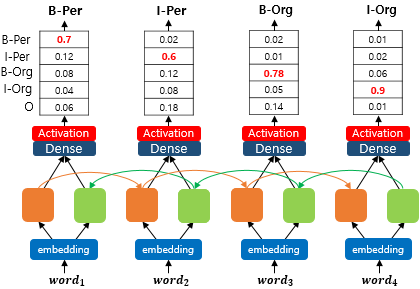)

- 위 모델은 각 단어를 벡터로 입력받고, 모델의 출력층에서 활성화 함수를 통해 개체명을 예측
- 입력 단어들과 실제 개체명이 무엇인지 모르는 상황이므로 이 모델이 정확하게 개체명을 예측했는지는 위 그림만으로는 알 수 없음

  ![bilstmcrf2_수정[1].PNG](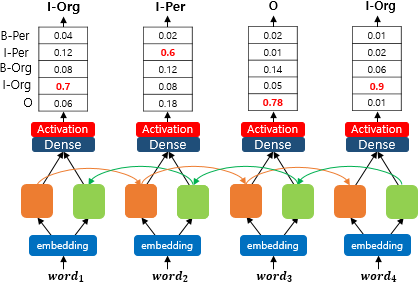)

- 위 모델은 명확히 틀린 예측을 포함
  -  **BIO 표현에 따르면 우선, 첫번째 단어의 레이블에서 I가 등장할 수 없음**
  - **I-Per은 반드시 B-Per 뒤에서만 등장가능**
  - **I-Org도 마찬가지로 B-Org 뒤에서만 등장가능**
  
  **위 모델은 이런 BIO 표현 방법의 제약사항들을 모두 위반**
  

  <br>

#### 양방향 LSTM 위에 CRF 층을 추가하여 얻을 수 있는 이점
- **CRF 층을 추가하면 모델은 예측 개체명, 다시 말해 레이블 사이의 의존성을 고려할 수 있음**
- 아래의 그림은 양방향 LSTM + CRF 모델을 보여줌

![bilstmcrf3[1].PNG](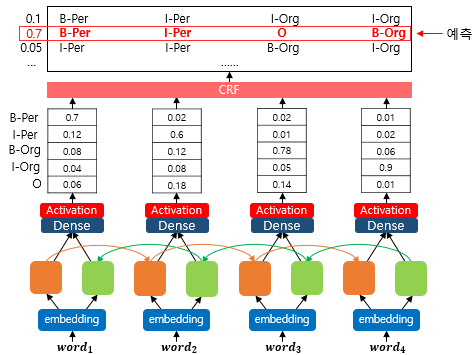)

- **기존 CRF 층이 존재하지 않았던 양방향 LSTM 모델은 활성화 함수를 지난 시점에서 개체명을 결정했지만,**

  **CRF 층을 추가한 모델에서는 활성화 함수의 결과들이 CRF 층의 입력으로 전달**

  - 예를 들어 $word_1$에 대한 양방향 LSTM 셀과 활성화 함수를 지난 출력값 [0.7, 0.12, 0.08, 0.04, 0.06]은 CRF 층의 입력
  - 마찬가지로 모든 단어에 대한 활성화 함수를 지난 출력값은 CRF 층의 입력이 되고, CRF 층은 레이블 시퀀스에 대해서 가장 높은 점수를 가지는 시퀀스를 예측

<br>

* **이러한 구조에서 CRF 층은 점차적으로 훈련 데이터로부터 아래와 같은 제약사항 등을 학습**
1. 문장의 첫번째 단어에서는 I가 나오지 않습니다.
2. O-I 패턴은 나오지 않습니다.
3. B-I-I 패턴에서 개체명은 일관성을 유지합니다.
4. B-Per 다음에 I-Org는 나오지 않습니다.

**양방향 LSTM은 입력 단어에 대한 양방향 문맥을 반영하며, CRF는 출력 레이블에 대한 양방향 문맥을 반영**

<br>

#### CRF층 설치

깃허브 링크 : https://github.com/luozhouyang/keras-crf



```python
pip install keras-crf
```

<br>

### BiLSTM-CRF를 이용한 개체명 인식

<br>

#### `keras_crf.CRFModel(model, units)`
- `model` : CRF층을 생성할 모델
- `units` : 출력층 크기

In [43]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, LSTM, Input, Bidirectional, TimeDistributed, Embedding, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras_crf import CRFModel
from seqeval.metrics import f1_score, classification_report

In [44]:
embedding_dim = 128
hidden_units = 64
dropout_ratio = 0.3
max_len = 70

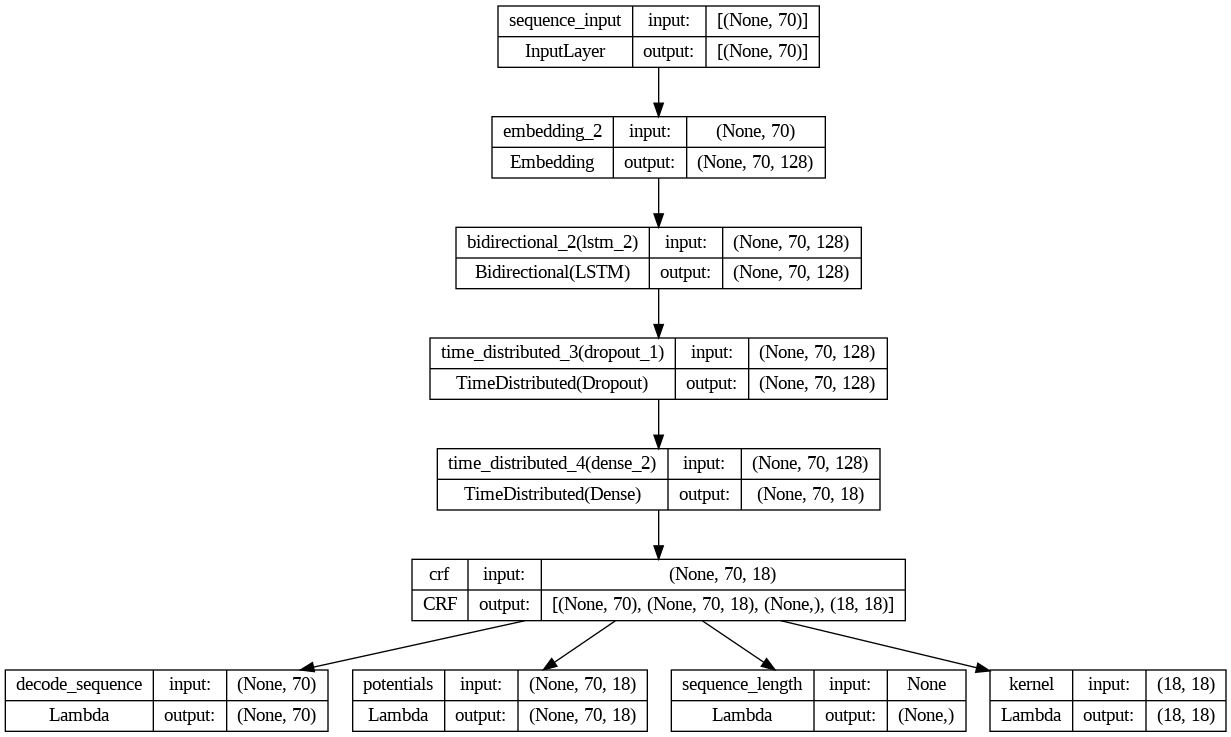

In [46]:
sequence_input = Input(shape=(max_len,),dtype=tf.int32, name='sequence_input')

model_embedding = Embedding(input_dim=vocab_size,
                            output_dim=embedding_dim,
                            input_length=max_len)(sequence_input)

model_bilstm = Bidirectional(LSTM(units=hidden_units, return_sequences=True))(model_embedding)

model_dropout = TimeDistributed(Dropout(dropout_ratio))(model_bilstm)

model_dense = TimeDistributed(Dense(tag_size, activation='relu'))(model_dropout)

base = Model(inputs=sequence_input, outputs=model_dense)

model = CRFModel(base, tag_size)
model.compile(optimizer=tf.keras.optimizers.Adam(0.001), metrics='accuracy')

plot_model(model, show_shapes=True)

In [49]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=False, patience=4)
mc = ModelCheckpoint('bilstm_crf/cp.ckpt', monitor='val_decode_sequence_accuracy',
                     mode='max', verbose=False, save_best_only=True, save_weights_only=True)

<br>

#### 모델 학습

In [50]:
history = model.fit(X_train, y_train_int,
                    batch_size=128, epochs=15,
                    validation_split=0.1, callbacks=[mc, es], verbose=False)

In [51]:
model.load_weights('bilstm_crf/cp.ckpt')

<br>

#### 모델 평가

In [52]:
i = 13

y_predicted = model.predict(np.array([X_test[i]]))[0]
labels = np.argmax(y_test[i], -1)

print("{:15}|{:5}|{}".format("단어", "실제값", "예측값"))
print(35 * "-")

for word, tag, pred in zip(X_test[i], labels, y_predicted[0]):
    if word != 0: # PAD값은 제외
        print("{:17}: {:7} {}".format(index_to_word[word], index_to_ner[tag], index_to_ner[pred]))

1/1 [==============================] - 2s 2s/step
단어             |실제값  |예측값
-----------------------------------
the              : O       O
statement        : O       O
came             : O       O
as               : O       O
u.n.             : B-org   B-org
secretary-general: I-org   I-org
kofi             : B-per   B-per
annan            : I-per   I-per
met              : O       O
with             : O       O
officials        : O       O
in               : O       O
amman            : B-geo   B-geo
to               : O       O
discuss          : O       O
wednesday        : B-tim   B-tim
's               : O       O
attacks          : O       O
.                : O       O


In [55]:
y_predicted = model.predict(X_test)[0]

300/300 [==============================] - 17s 57ms/step


In [56]:
print(y_predicted[:2])

[[ 1  3 10  1  2  1  1  1  1  1  1  1  1  1  1  1  1  1  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  1  1  1  1  1  3  1  1  1  1  1  1  1  2  9  9  1  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]]


<br>

#### 태깅 정보 시퀀스를 리턴하는 함수

In [53]:
def sequences_to_tag_for_crf(sequences):
    result = []

    for sequence in sequences:
        word_sequence = []

        for pred_index in sequence:
            # index_to_ner을 사용하여 정수를 태깅 정보로 변환. 'PAD'는 'O'로 변경.
            word_sequence.append(index_to_ner[pred_index].replace("PAD", "O"))
        result.append(word_sequence)

    return result

In [59]:
pred_tags = sequences_to_tag_for_crf(y_predicted)
test_tags = sequences_to_tag(y_test)

print("F1-score: {:.1%}".format(f1_score(test_tags, pred_tags)))
print(classification_report(test_tags, pred_tags))

F1-score: 79.2%
              precision    recall  f1-score   support

         art       0.00      0.00      0.00        63
         eve       0.75      0.06      0.11        52
         geo       0.83      0.84      0.83      7620
         gpe       0.95      0.94      0.94      3145
         nat       0.50      0.03      0.05        37
         org       0.65      0.57      0.61      4033
         per       0.75      0.70      0.72      3545
         tim       0.86      0.82      0.84      4067

   micro avg       0.81      0.78      0.79     22562
   macro avg       0.66      0.50      0.51     22562
weighted avg       0.80      0.78      0.79     22562



<br>

<br>

## 문자 임베딩(Character Embedding) 활용

<br>

### 문자 임베딩(Char Embedding)을 위한 전처리

- 문자 임베딩을 위해서 하고자 하는 전처리는 문자 단위 정수 인코딩
  - 단어 'book'이 있고, b가 21번 o가 7번, k가 11번이라고 한다면 단어 'book'을 `[21 7 7 11]`로 인코딩
  - 만약 단어 1개가 아니라 단어구 내지는 문장이라면?
  - 'good book'이란 문장이 있고, g가 12번, d가 17번이라고 한다면 이 문장을 문자 단위 정수 인코딩 후에는 다음과 같은 결과

  - 'good book의 정수 인코딩 결과'

    ```
    [[12 7 7 17], [21 7 7 11]]
    ```

<br>

- 각 문자와 맵핑된 정수를 각각 임베딩 층(Embedding layer)을 거치도록 하여, 문자 단위 임베딩을 얻음
- 임베딩 층을 통과시키기 위해 문자에 대한 정수 인코딩
  - 전체 데이터의 모든 단어를 문자 레벨로 분해하여, 문자 집합을 생성

In [61]:
words = list(set(data["Word"].values))
chars = set([w_i for w in words for w_i in w])
chars = sorted(list(chars))
print('문자 집합 :',chars)

문자 집합 : ['!', '"', '#', '$', '%', '&', "'", '(', ')', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', '@', '[', ']', '_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '~', '\x85', '\x91', '\x92', '\x93', '\x94', '\x96', '\x97', '\xa0', '°', 'é', 'ë', 'ö', 'ü']


- 문자 집합으로부터 문자를 정수로 변환할 수 있는 딕셔너리인 char_to_index와 반대로,

   정수로부터 문자를 얻을 수 있는 딕셔너리인 index_to_char를 생성

In [62]:
char_to_index = {c: i + 2 for i, c in enumerate(chars)}
char_to_index["OOV"] = 1
char_to_index["PAD"] = 0

index_to_char = {}
for key, value in char_to_index.items():
    index_to_char[value] = key

- 단어를 표현하는 문자 시퀀스의 최대 길이는 15로 제한 후 패딩

In [63]:
max_len_char = 15

In [67]:
# 문자 시퀀스에 대한 패딩하는 함수
def padding_char_indice(char_indice, max_len_char):
  return pad_sequences(char_indice, maxlen=max_len_char, padding='post', value = 0)

In [68]:
# 각 단어를 문자 시퀀스로 변환 후 패딩 진행
def integer_coding(sentences):
  char_data = []

  for ts in sentences:

    word_indice = [word_to_index[t] for t in ts]
    char_indice = [[char_to_index[char] for char in t]
                                          for t in ts]
    char_indice = padding_char_indice(char_indice, max_len_char)

    for chars_of_token in char_indice:

      if len(chars_of_token) > max_len_char:
        continue
    char_data.append(char_indice)

  return char_data

In [69]:
# 문자 단위 정수 인코딩 결과
X_char_data = integer_coding(sentences)

<br>

- 동일한 문장에 대해서 단어 단위 정수 인코딩과 문자 단위 정수 인코딩의 차이를 확인

In [70]:
print('기존 문장 :',sentences[0])

기존 문장 : ['thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'london', 'to', 'protest', 'the', 'war', 'in', 'iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'british', 'troops', 'from', 'that', 'country', '.']


In [71]:
print('단어 단위 정수 인코딩 :')
print(X_data[0])

단어 단위 정수 인코딩 :
[ 254    6  967   16 1795  238  468    7  523    2  129    5   61    9
  571    2  833    6  186   90   22   15   56    3    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0]


- 출력 결과에서 각 행은 각 단어를 의미
  
   thousands는 첫번째 행 [53 41 48 54 52 34 47 37 52 0 0 0 0 0 0]에 해당
- **단어의 최대 길이를 15(max_len_char)로 제한하였으므로, 길이가 15보다 짧은 단어는 뒤에 0으로 패딩**
- 53은 t, 41은 h, 48은 o, 54는 u에 각각 해당

In [72]:
print('문자 단위 정수 인코딩 :')
print(X_char_data[0])

문자 단위 정수 인코딩 :
[[53 41 48 54 52 34 47 37 52  0  0  0  0  0  0]
 [48 39  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [37 38 46 48 47 52 53 51 34 53 48 51 52  0  0]
 [41 34 55 38  0  0  0  0  0  0  0  0  0  0  0]
 [46 34 51 36 41 38 37  0  0  0  0  0  0  0  0]
 [53 41 51 48 54 40 41  0  0  0  0  0  0  0  0]
 [45 48 47 37 48 47  0  0  0  0  0  0  0  0  0]
 [53 48  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [49 51 48 53 38 52 53  0  0  0  0  0  0  0  0]
 [53 41 38  0  0  0  0  0  0  0  0  0  0  0  0]
 [56 34 51  0  0  0  0  0  0  0  0  0  0  0  0]
 [42 47  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [42 51 34 50  0  0  0  0  0  0  0  0  0  0  0]
 [34 47 37  0  0  0  0  0  0  0  0  0  0  0  0]
 [37 38 46 34 47 37  0  0  0  0  0  0  0  0  0]
 [53 41 38  0  0  0  0  0  0  0  0  0  0  0  0]
 [56 42 53 41 37 51 34 56 34 45  0  0  0  0  0]
 [48 39  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [35 51 42 53 42 52 41  0  0  0  0  0  0  0  0]
 [53 51 48 48 49 52  0  0  0  0  0  0  0  0  0]
 [39 51 48 46  0  0  0  0

<br>

- X_data는 뒤에 0으로 패딩되어 길이가 70인 것에 비해 X_char_data는 현재 0번 단어는 무시되어 길이가 70이 아님
- **다시 말해 위 출력 결과에서 행의 개수가 70이 아닌 상태**
- **길이를 70으로 맞춰주기 위해서 문장 길이 방향으로도 패딩**

In [73]:
X_char_data = pad_sequences(X_char_data, maxlen=max_len, padding='post', value = 0)

<br>

#### 훈련/테스트 데이터 분할

In [74]:
X_char_train, X_char_test, _, _ = train_test_split(X_char_data, y_data, test_size=.2, random_state=777)

X_char_train = np.array(X_char_train)
X_char_test = np.array(X_char_test)

In [75]:
print(X_train[0])

[ 150  928  361   17 2624    9 4131 3567    9    8 2893 1250  880  107
    3    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0]


<br>



In [76]:
print(index_to_word[150])

soldiers


In [77]:
print(' '.join([index_to_char[index] for index in X_char_train[0][0]]))

s o l d i e r s PAD PAD PAD PAD PAD PAD PAD


In [79]:
print('훈련 샘플 문장의 크기 : {}'.format(X_train.shape))
print('훈련 샘플 레이블의 크기 : {}'.format(y_train.shape))
print('훈련 샘플 char 데이터의 크기 : {}'.format(X_char_train.shape), end='\n\n')
print('테스트 샘플 문장의 크기 : {}'.format(X_test.shape))
print('테스트 샘플 레이블의 크기 : {}'.format(y_test.shape))

훈련 샘플 문장의 크기 : (38367, 70)
훈련 샘플 레이블의 크기 : (38367, 70, 18)
훈련 샘플 char 데이터의 크기 : (38367, 70, 15)

테스트 샘플 문장의 크기 : (9592, 70)
테스트 샘플 레이블의 크기 : (9592, 70, 18)


<br>

### BiLSTM-CNN을 이용한 개체명 인식

In [80]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Input, TimeDistributed, Dropout, concatenate, Bidirectional, LSTM, Conv1D, Dense, MaxPooling1D, Flatten
from tensorflow.keras import Model
from tensorflow.keras.initializers import RandomUniform
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from seqeval.metrics import f1_score, classification_report
from keras_crf import CRFModel

In [81]:
embedding_dim = 128
char_embedding_dim = 64
dropout_ratio = 0.5
hidden_units = 256
num_filters = 30
kernel_size = 3

<br>

#### 모델 생성

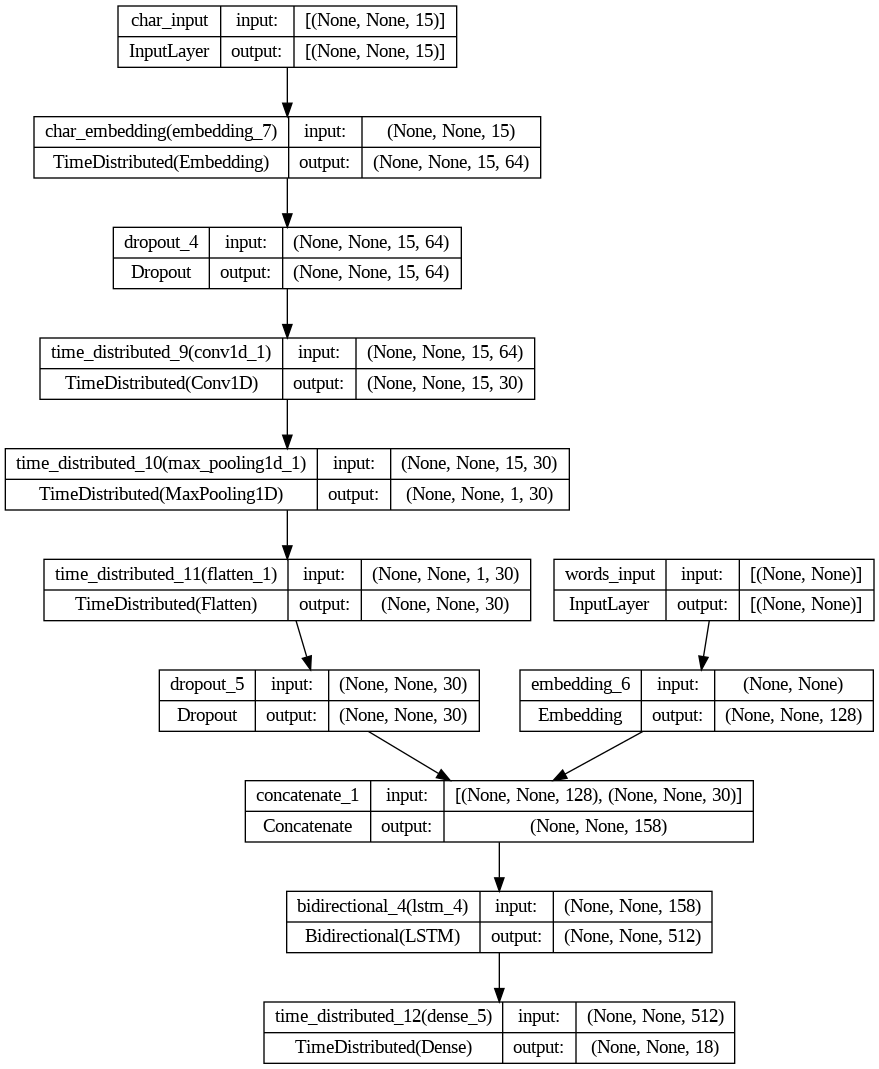

In [93]:
# 단어 임베딩
word_ids = Input(shape=(None,),dtype='int32', name='words_input')
word_embeddings = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(word_ids)

# char 임베딩
char_ids = Input(shape=(None, max_len_char,), name='char_input')
embed_char_out = TimeDistributed(Embedding(len(char_to_index), char_embedding_dim, embeddings_initializer=RandomUniform(minval=-0.5, maxval=0.5)), name='char_embedding')(char_ids)
dropout = Dropout(dropout_ratio)(embed_char_out)

# char 임베딩에 대해서는 Conv1D 수행
conv1d_out = TimeDistributed(Conv1D(kernel_size=kernel_size, filters=num_filters, padding='same', activation='tanh', strides=1))(dropout)
maxpool_out = TimeDistributed(MaxPooling1D(max_len_char))(conv1d_out)
char_embeddings = TimeDistributed(Flatten())(maxpool_out)
char_embeddings = Dropout(dropout_ratio)(char_embeddings)

# char 임베딩을 Conv1D 수행한 뒤에 단어 임베딩과 연결
output = concatenate([word_embeddings, char_embeddings])

# 연결한 벡터를 가지고 문장의 길이만큼 LSTM을 수행
output = Bidirectional(LSTM(hidden_units, return_sequences=True, dropout=dropout_ratio))(output)

# 출력층
output = TimeDistributed(Dense(tag_size, activation='softmax'))(output)

model = Model(inputs=[word_ids, char_ids], outputs=[output])

plot_model(model, show_shapes=True)

In [85]:
model.compile(loss='categorical_crossentropy', optimizer='nadam',  metrics=['acc'])

In [86]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=False, patience=4)
mc = ModelCheckpoint('bilstm_cnn.h5', monitor='val_acc', mode='max', verbose=False, save_best_only=True)

<br>

#### 모델 학습

In [ ]:
history = model.fit([X_train, X_char_train], y_train,
                    batch_size=128, epochs=15, validation_split=0.1,
                    verbose=False, callbacks=[es, mc])

<br>

#### 모델 평가

In [89]:
model = load_model('bilstm_cnn.h5')

In [90]:
i = 13

y_predicted = model.predict([np.array([X_test[i]]), np.array([X_char_test[i]])])

y_predicted = np.argmax(y_predicted, axis=-1)
labels = np.argmax(y_test[i], -1)

print("{:15}|{:5}|{}".format("단어", "실제값", "예측값"))
print(35 * "-")

1/1 [==============================] - 1s 1s/step
단어             |실제값  |예측값
-----------------------------------


In [91]:
for word, tag, pred in zip(X_test[i], labels, y_predicted[0]):

    if word != 0: # PAD값은 제외
        print("{:17}: {:7} {}".format(index_to_word[word], index_to_ner[tag], index_to_ner[pred]))

the              : O       O
statement        : O       O
came             : O       O
as               : O       O
u.n.             : B-org   B-org
secretary-general: I-org   I-org
kofi             : B-per   B-per
annan            : I-per   I-per
met              : O       O
with             : O       O
officials        : O       O
in               : O       O
amman            : B-geo   B-geo
to               : O       O
discuss          : O       O
wednesday        : B-tim   B-tim
's               : O       O
attacks          : O       O
.                : O       O


In [92]:
y_predicted = model.predict([X_test, X_char_test])
pred_tags = sequences_to_tag(y_predicted)
test_tags = sequences_to_tag(y_test)

print("F1-score: {:.1%}".format(f1_score(test_tags, pred_tags)))
print(classification_report(test_tags, pred_tags))

300/300 [==============================] - 3s 9ms/step
F1-score: 78.7%


/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         art       0.00      0.00      0.00        63
         eve       0.82      0.17      0.29        52
         geo       0.83      0.84      0.84      7620
         gpe       0.94      0.95      0.94      3145
         nat       0.00      0.00      0.00        37
         org       0.59      0.56      0.57      4033
         per       0.73      0.71      0.72      3545
         tim       0.85      0.85      0.85      4067

   micro avg       0.79      0.78      0.79     22562
   macro avg       0.59      0.51      0.53     22562
weighted avg       0.79      0.78      0.78     22562



<br>

### BiLSTM-CNN-CRF

<br>

#### 모델 생성

In [94]:
embedding_dim = 128
char_embedding_dim = 64
dropout_ratio = 0.5
hidden_units = 256
num_filters = 30
kernel_size = 3

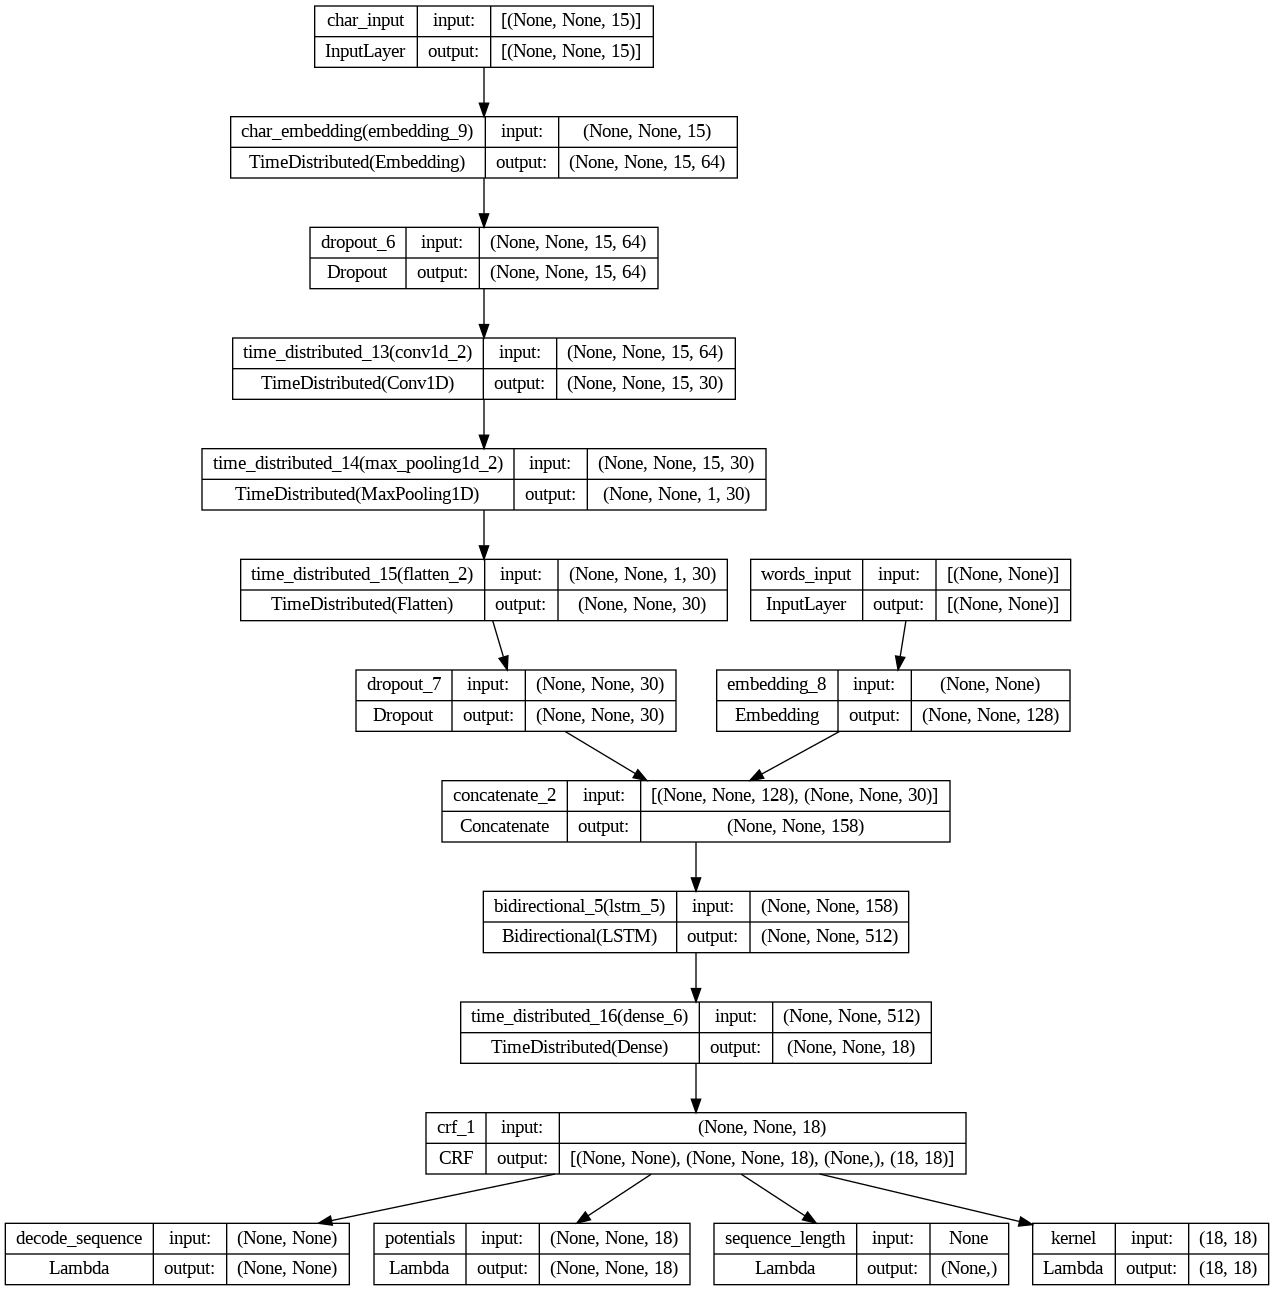

In [95]:
# 단어 임베딩
word_ids = Input(shape=(None,),dtype='int32', name='words_input')
word_embeddings = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(word_ids)

# char 임베딩
char_ids = Input(shape=(None, max_len_char,), name='char_input')
embed_char_out = TimeDistributed(Embedding(len(char_to_index), char_embedding_dim, embeddings_initializer=RandomUniform(minval=-0.5, maxval=0.5)), name='char_embedding')(char_ids)
dropout = Dropout(dropout_ratio)(embed_char_out)

# char 임베딩에 대해서는 Conv1D 수행
conv1d_out = TimeDistributed(Conv1D(kernel_size=kernel_size, filters=num_filters, padding='same',activation='tanh', strides=1))(dropout)
maxpool_out=TimeDistributed(MaxPooling1D(max_len_char))(conv1d_out)
char_embeddings = TimeDistributed(Flatten())(maxpool_out)
char_embeddings = Dropout(dropout_ratio)(char_embeddings)

# char 임베딩을 Conv1D 수행한 뒤에 단어 임베딩과 연결
output = concatenate([word_embeddings, char_embeddings])

# 연결한 벡터를 가지고 문장의 길이만큼 LSTM을 수행
output = Bidirectional(LSTM(hidden_units, return_sequences=True, dropout=dropout_ratio))(output)

# 출력층
output = TimeDistributed(Dense(tag_size, activation='relu'))(output)

base = Model(inputs=[word_ids, char_ids], outputs=[output])
model = CRFModel(base, tag_size)

plot_model(model, show_shapes=True)

In [96]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.001), metrics='accuracy')

In [97]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=False, patience=4)
mc = ModelCheckpoint('bilstm_cnn_crf/cp.ckpt', monitor='val_decode_sequence_accuracy',
                     mode='max', verbose=False, save_best_only=True, save_weights_only=True)

<br>

#### 모델 학습
- **CRF 층은 원-핫 인코딩 된 레이블은 지원하지 않으므로 y_train이 아니라 y_train_int를 사용**

In [98]:
history = model.fit([X_train, X_char_train], y_train_int,
                    batch_size=128, epochs=15, validation_split=0.1,
                    verbose=False, callbacks=[mc, es])

<br>

#### 모델 평가

In [99]:
model.load_weights('bilstm_cnn_crf/cp.ckpt')

In [100]:
i = 13

y_predicted = model.predict([np.array([X_test[i]]), np.array([X_char_test[i]])])[0]
labels = np.argmax(y_test[i], -1)

print("{:15}|{:5}|{}".format("단어", "실제값", "예측값"))
print(35 * "-")

1/1 [==============================] - 1s 1s/step
단어             |실제값  |예측값
-----------------------------------


In [101]:
for word, tag, pred in zip(X_test[i], labels, y_predicted[0]):

    if word != 0: # PAD값은 제외
        print("{:17}: {:7} {}".format(index_to_word[word], index_to_ner[tag], index_to_ner[pred]))

the              : O       O
statement        : O       O
came             : O       O
as               : O       O
u.n.             : B-org   B-org
secretary-general: I-org   I-org
kofi             : B-per   B-per
annan            : I-per   I-per
met              : O       O
with             : O       O
officials        : O       O
in               : O       O
amman            : B-geo   B-geo
to               : O       O
discuss          : O       O
wednesday        : B-tim   B-tim
's               : O       O
attacks          : O       O
.                : O       O


In [102]:
y_predicted = model.predict([X_test, X_char_test])[0]
pred_tags = sequences_to_tag_for_crf(y_predicted)
test_tags = sequences_to_tag(y_test)

print("F1-score: {:.1%}".format(f1_score(test_tags, pred_tags)))
print(classification_report(test_tags, pred_tags))

300/300 [==============================] - 17s 55ms/step
F1-score: 80.6%
              precision    recall  f1-score   support

         art       0.00      0.00      0.00        63
         eve       0.87      0.25      0.39        52
         geo       0.81      0.87      0.84      7620
         gpe       0.95      0.93      0.94      3145
         nat       0.50      0.03      0.05        37
         org       0.72      0.53      0.61      4033
         per       0.79      0.73      0.76      3545
         tim       0.86      0.85      0.86      4067

   micro avg       0.83      0.79      0.81     22562
   macro avg       0.69      0.52      0.56     22562
weighted avg       0.82      0.79      0.80     22562



<br>

### BiLSTM-BiLSTM-CRF

- 하나의 단어는 문자 단위로 토큰화되었고, 토큰화 된 각 문자는 전처리를 통해 정수로 맵핑된 상태
- 정수로 맵핑된 각 문자는 임베딩 층을 통과하면 64차원의 벡터
- 이후 양방향 LSTM 입력으로 사용되는, LSTM의 은닉 상태의 크기는 64
- 해당 LSTM은 다 대 일(many-to-one)구조로 순방향 LSTM의 은닉 상태와 역방향 LSTM의 은닉 상태가 연결(concatenate)된 값이 양방향 LSTM의 출력
- 해당 출력을 하나의 단어에 대한 단어 벡터로 간주
- 해당 단어 벡터는 일반적으로 워드 임베딩이라고 부르던 과정을 통해 얻은 단어의 임베딩 벡터와 연결(concatenate)
- 이를 개체명 인식을 위한 양방향 LSTM의 입력으로 사용

<br>

- **CRF 층은 원-핫 인코딩 된 레이블은 지원하지 않으므로 y_train_int를 사용**

<br>

#### 모델 생성

In [103]:
embedding_dim = 128
char_embedding_dim = 64
dropout_ratio = 0.3
hidden_units = 64

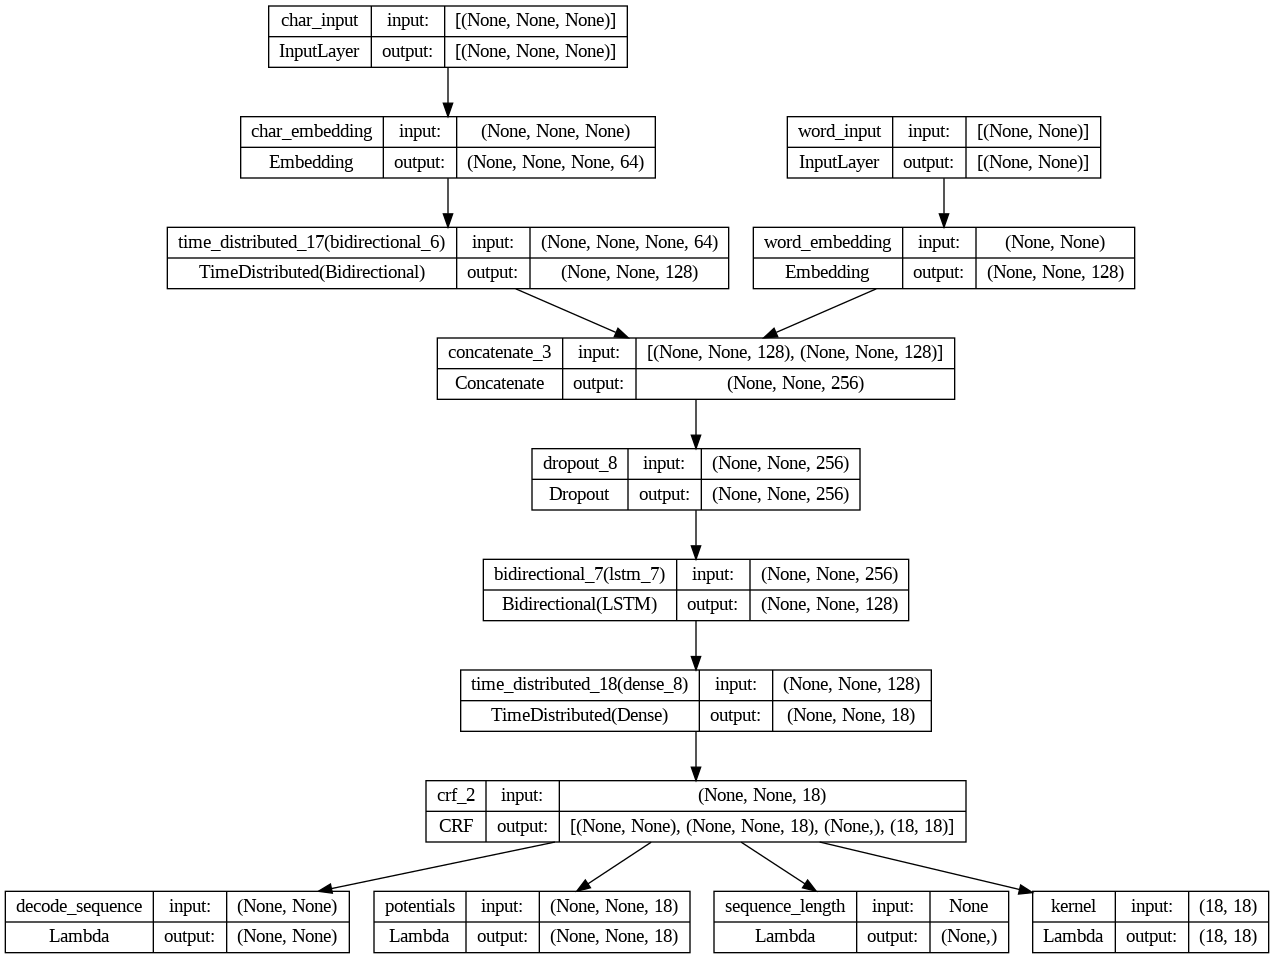

In [104]:
# 단어 임베딩
word_ids = Input(batch_shape=(None, None), dtype='int32', name='word_input')
word_embeddings = Embedding(input_dim=vocab_size,
                                        output_dim=embedding_dim,
                                        name='word_embedding')(word_ids)

# char 임베딩
char_ids = Input(batch_shape=(None, None, None), dtype='int32', name='char_input')
char_embeddings = Embedding(input_dim=(len(char_to_index)),
                                        output_dim=char_embedding_dim,
                                        embeddings_initializer=RandomUniform(minval=-0.5, maxval=0.5),
                                        name='char_embedding')(char_ids)

# char 임베딩을 BiLSTM을 통과 시켜 단어 벡터를 얻고 단어 임베딩과 연결
char_embeddings = TimeDistributed(Bidirectional(LSTM(hidden_units)))(char_embeddings)
output = concatenate([word_embeddings, char_embeddings])

# 연결한 벡터를 가지고 문장의 길이만큼 LSTM을 수행
output = Dropout(dropout_ratio)(output)
output = Bidirectional(LSTM(units=hidden_units, return_sequences=True))(output)

# 출력층
output = TimeDistributed(Dense(tag_size, activation='relu'))(output)

base = Model(inputs=[word_ids, char_ids], outputs=[output])
model = CRFModel(base, tag_size)

plot_model(model, show_shapes=True)

In [105]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.001), metrics='accuracy')

In [106]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=False, patience=4)
mc = ModelCheckpoint('bilstm_bilstm_crf/cp.ckpt', monitor='val_decode_sequence_accuracy',
                     mode='max', verbose=False, save_best_only=True, save_weights_only=True)

<br>

#### 모델 학습

In [107]:
history = model.fit([X_train, X_char_train], y_train_int,
                    batch_size=128, epochs=15, validation_split=0.1,
                    verbose=False, callbacks=[mc, es])

<br>

#### 모델 평가

In [108]:
model.load_weights('bilstm_bilstm_crf/cp.ckpt')

In [109]:
i = 13

y_predicted = model.predict([np.array([X_test[i]]), np.array([X_char_test[i]])])[0]
labels = np.argmax(y_test[i], -1)

print("{:15}|{:5}|{}".format("단어", "실제값", "예측값"))
print(35 * "-")

1/1 [==============================] - 2s 2s/step
단어             |실제값  |예측값
-----------------------------------


In [110]:
for word, tag, pred in zip(X_test[i], labels, y_predicted[0]):

    if word != 0: # PAD값은 제외
        print("{:17}: {:7} {}".format(index_to_word[word], index_to_ner[tag], index_to_ner[pred]))

the              : O       O
statement        : O       O
came             : O       O
as               : O       O
u.n.             : B-org   B-org
secretary-general: I-org   I-org
kofi             : B-per   B-per
annan            : I-per   I-per
met              : O       O
with             : O       O
officials        : O       O
in               : O       O
amman            : B-geo   B-geo
to               : O       O
discuss          : O       O
wednesday        : B-tim   B-tim
's               : O       O
attacks          : O       O
.                : O       O


In [111]:
y_predicted = model.predict([X_test, X_char_test])[0]
pred_tags = sequences_to_tag_for_crf(y_predicted)
test_tags = sequences_to_tag(y_test)

print("F1-score: {:.1%}".format(f1_score(test_tags, pred_tags)))
print(classification_report(test_tags, pred_tags))

300/300 [==============================] - 17s 57ms/step
F1-score: 81.3%
              precision    recall  f1-score   support

         art       0.00      0.00      0.00        63
         eve       0.86      0.23      0.36        52
         geo       0.83      0.87      0.85      7620
         gpe       0.95      0.94      0.95      3145
         nat       0.00      0.00      0.00        37
         org       0.68      0.57      0.62      4033
         per       0.78      0.76      0.77      3545
         tim       0.88      0.85      0.86      4067

   micro avg       0.82      0.80      0.81     22562
   macro avg       0.62      0.53      0.55     22562
weighted avg       0.82      0.80      0.81     22562

